# Solve the "time-like" KdV equation

"time-like" meaning the spatial and temporal variables are interchanged. Lamb simply calls it the equation in $s-x$ space. He refers to the "normal" equation as physical $x-t$ space.

See e.g. Grimshaw (2007), Holloway 1999, ...

The main equation in $s-x$ space is:

$$
\frac{\partial \zeta}{\partial x} + \alpha\frac{Q}{c^2}\zeta \frac{\partial \zeta}{\partial s}
    + \frac{\beta}{c^4}\frac{\partial^3\beta}{\partial s^3} = \frac{f^2}{2c}\int_{-\infty}^s \zeta ds
$$

where

$$
\zeta(x,s) = \frac{\eta(x,t)}{Q(x)}
$$

$$
s=\int_0^x\frac{dx}{c}-t
$$

We solve using the pseudo-spectral method https://scipy-cookbook.readthedocs.io/items/KdV.html

In [36]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.fftpack import diff as psdiff

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [63]:
def kdv(zeta, x, T, Q, c, alpha, beta):
    """Differential equations for the KdV equation, discretized in s."""
    # Compute the x derivatives using the pseudo-spectral method.
    zetas = psdiff(zeta, period=T)
    zetasss = psdiff(zeta, period=T, order=3)
    
    c2 = c*c
    c4 = c2*c2
    # Compute du/dt.    
    dzetadx = -alpha*Q/c2 * zeta * zetas - beta/c4 * zetasss

    return dzetadx

def kdv_solution(zeta0, x, T, Q, c, alpha, beta):
    """Use odeint to solve the KdV equation on a periodic domain.

    `L` is the length of the periodic
    domain.
    """
    sol = odeint(kdv, zeta0, x, args=(T, Q, c, alpha, beta), mxstep=5000, printmessg=True)
    return sol



def kdvx_solution(eta0, t, L, c, alpha, beta, method='RK45'):
    """Use odeint to solve the KdV equation on a periodic domain.

    `L` is the length of the periodic
    domain.
    """
    def kdvx(t,eta):
        """Differential equations for the KdV equation, discretized in physical x-t space"""
        # Compute the x derivatives using the pseudo-spectral method.
        etax= psdiff(eta, period=L)
        etaxxx = psdiff(eta, period=L, order=3)

        detadt = -(c + alpha*eta)*etax - beta*etaxxx

        return detadt
    
    #sol = odeint(kdvx, eta, t, args=(L, c, alpha, beta), mxstep=5000, )
    sol = solve_ivp(kdvx, (t[0],t[-1]), eta0,  \
                #args=(L, c, alpha, beta), \
                   t_eval=t,\
                   #dense_output=True,
                   method=method)

    return sol

In [10]:
%%time
# Set the size of the domain, and create the discretized grid.

# Spatial domain
L=1.0e5
dx = 100
x = np.arange(0,L+dx,dx)
nx = x.shape[0]

# Time domain (x and t must be the same size as they are linked through s)
T = 12.42*3600
t = np.linspace(0,T,nx)

# parameters
ones = np.ones_like(x)
#ones=1
c = 1.15*ones
alpha = -0.035*ones 
beta = 1000.*ones
Q = 1.*ones

s = np.cumsum(1/c * dx) - t
Ts = np.abs(s[-1]-s[0])
#s = t

# Set the initial conditions.

zeta0 = 10*np.sin(2*np.pi/(T) * t)

#print("Computing the solution.")
sol = kdv_solution(zeta0, x, Ts, Q, c, alpha, beta) 

CPU times: user 12.2 s, sys: 60 ms, total: 12.2 s
Wall time: 12.3 s


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/integrate/odepack.py:221: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


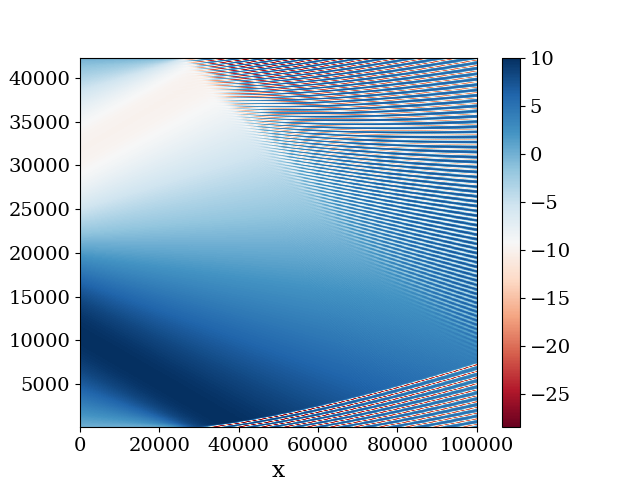

Text(0.5, 0, 'x')

In [11]:
plt.figure()
plt.pcolormesh(x,s,sol.T, cmap='RdBu')
plt.colorbar()
plt.ylabel('s')
plt.xlabel('x')

<IPython.core.display.Javascript object>


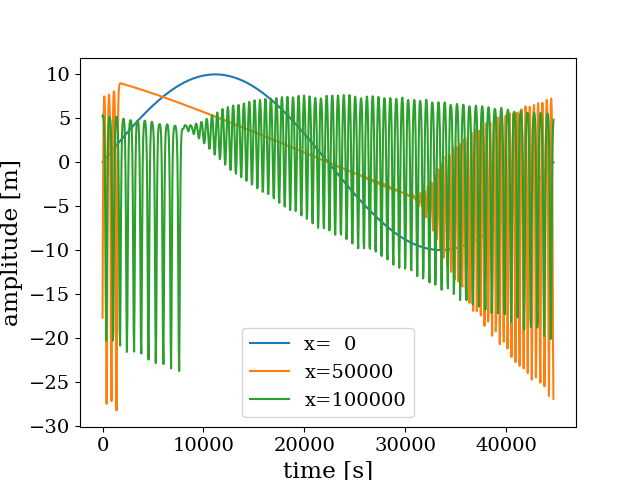

Text(0, 0.5, 'amplitude [m]')

In [12]:
plt.figure()
plt.plot(t,sol.T[:,0])
plt.plot(t,sol.T[:,nx//2])
plt.plot(t,sol.T[:,-1])
plt.legend(('x=%3.0f'%x[0],'x=%3.0f'%x[nx//2],'x=%3.0f'%x[-1]))
plt.xlabel('time [s]')
plt.ylabel('amplitude [m]')

<IPython.core.display.Javascript object>


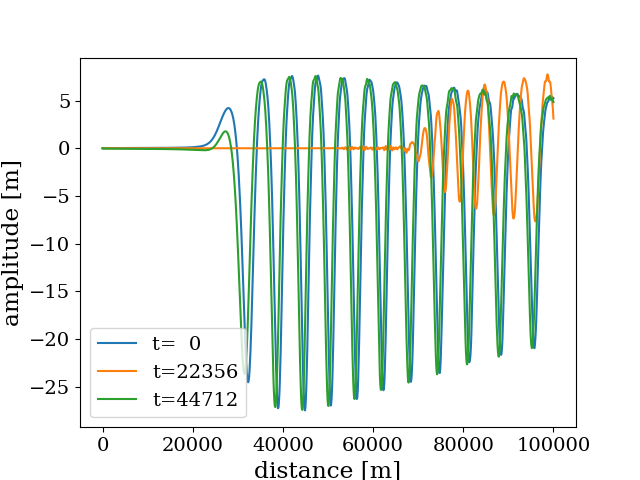

Text(0, 0.5, 'amplitude [m]')

In [13]:
plt.figure()
plt.plot(x,sol.T[0,:])
plt.plot(x,sol.T[nx//2,:])
plt.plot(x,sol.T[-1,:])
plt.legend(('t=%3.0f'%t[0],'t=%3.0f'%t[nx//2],'t=%3.0f'%t[-1]))
plt.xlabel('distance [m]')
plt.ylabel('amplitude [m]')

# Solve the equations in physical $x-t$ space

In [115]:
%%time
# Set the size of the domain, and create the discretized grid.

# Spatial domain
L=1.0e5 # Wave length
dx = 250
x = np.arange(0,L+dx,dx)
nx = x.shape[0]

# Time domain (x and t must be the same size as they are linked through s)
T = 12.42*3600
dt=60
t = np.arange(0,1.5*T,dt)
nt = t.shape[0]

# parameters
#ones = np.ones_like(x)
ones=1
c = 1.15*ones
alpha = -0.035*ones 
beta = 3000.*ones

# Set the initial conditions.
Lw = L/4
#zeta0 = 10*np.sin(2*np.pi/(Lw) * x) 
zeta0 = 10*np.exp(- (x - Lw*0.75)**2/(0.16*Lw**2)) # Gaussian IC
#plt.figure()
#plt.plot(x,zeta0)
print("Computing the solution.")
sol = kdvx_solution(zeta0, t, Lw , c, alpha, beta, method='RK45') 

Computing the solution.
CPU times: user 1min 22s, sys: 240 ms, total: 1min 22s
Wall time: 1min 23s


<IPython.core.display.Javascript object>


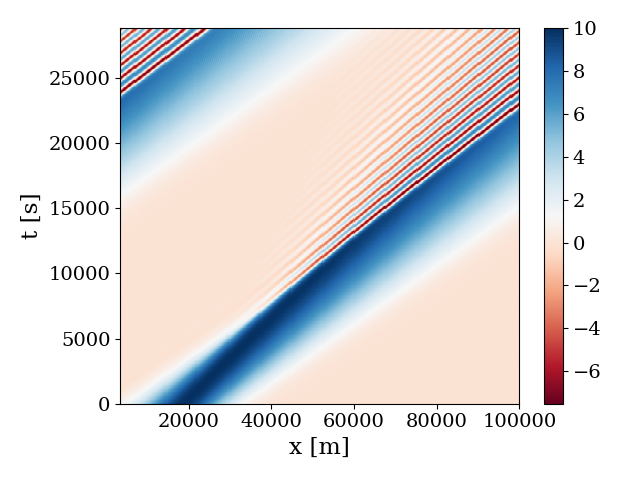

In [116]:
plt.figure()
plt.pcolormesh(x,sol.t,sol.y.T, cmap='RdBu')
plt.colorbar()
plt.ylabel('t [s]')
plt.xlabel('x [m]')
plt.tight_layout()

<IPython.core.display.Javascript object>


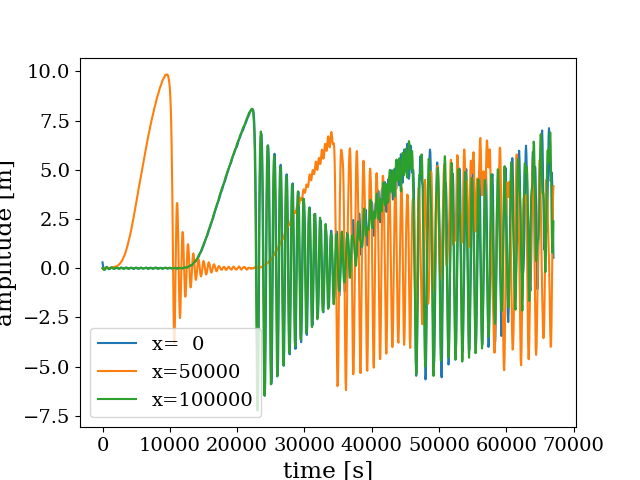

Text(0, 0.5, 'amplitude [m]')

In [117]:
plt.figure()
plt.plot(sol.t,sol.y.T[:,0])
plt.plot(sol.t,sol.y.T[:,nx//2])
plt.plot(sol.t,sol.y.T[:,-1])
plt.legend(('x=%3.0f'%x[0],'x=%3.0f'%x[nx//2],'x=%3.0f'%x[-1]))
plt.xlabel('time [s]')
plt.ylabel('amplitude [m]')

<IPython.core.display.Javascript object>


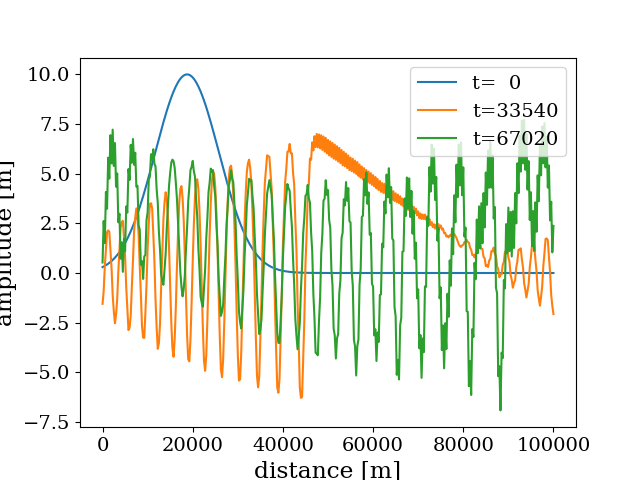

Text(0, 0.5, 'amplitude [m]')

In [118]:
plt.figure()
plt.plot(x,sol.y.T[0,:])
plt.plot(x,sol.y.T[nt//2,:])
plt.plot(x,sol.y.T[-1,:])
plt.legend(('t=%3.0f'%t[0],'t=%3.0f'%t[nt//2],'t=%3.0f'%t[-1]))
plt.xlabel('distance [m]')
plt.ylabel('amplitude [m]')